# Hyperbolic Embedding Methods for Medical Entity Relations
<br>

**Drew Wilimitis** <br> 
Department of Biomedical Informatics, Vanderbilt University Medical Center

![title](images/three_models.png)

### Abstract :
Electronic Health Records are other sources of clinical data are often unstructured, non-standardized, and contain heterogeneous data. This presents a significant challenge for building accurate and robust predictive models, as most standard supervised learning algorithms require uniformly formatted training datasets with informative feature vectors. Therefore, it is necessary to learn representations of these datasets that preserve their underlying, multi-layered relationships. There is a wide variety of methods for representation learning of Electronic Health Records **[1]**, including attempts to represent hierarchical relationships often found within taxonomies and concept networks. We compare a variety of hyperbolic embedding algorithms and their ability to learn low-distortion embeddings of ICD-9 codes. We then demonstrate the utility of these embeddings and the insights they reveal.

### 2. Background Overview of Hyperbolic Geometry:


### 3.1-3.4: Hyperbolic Embeddings
- Method 1: Apply the Poincare Embedding Algorithm
- Method 2: Apply Lorentz Embedding
- Method 3: Lorentzian Distance Learning??
- Method 4: hMDS

### 4.  Evaluation Comparison (Between Euclidean & Earlier Approach) <br>

### 5. Apply Hyperbolic KMeans/Clustering?<br>

### 6. Apply to real EHR data and build model with embedding features?

# Initial Data and Process Exploration 
**source:** https://github.com/brettbj/PoincareEmbeddings/tree/master/data

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
import networkx as nx
import sys
import os

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

In [2]:
all_codes = pd.read_csv('data/tmp/allcodes.csv', sep="|" , encoding='latin1', false_values=['"'])
majors = pd.read_csv('data/tmp/majors.csv', sep="|")
chapters = pd.read_csv('data/tmp/chapters.csv', sep="|").transpose()
sub_chapters = pd.read_csv('./data/tmp/subchapters.csv', sep="|").transpose()

df = pd.DataFrame(columns=['parent', 'child'])
# print(all_codes.head(3))

# handle chapters
chapters = chapters.reset_index()
chapters.columns = ['name', 'start', 'end']
chapters['range'] = 'c_' + chapters['start'].map(str) + '_' + chapters['end'].map(str)

chap_name_dict = dict(zip(chapters['name'], chapters['range']))
chap_range_dict = dict(zip(chapters['range'], chapters['name']))

sub_chapters = sub_chapters.reset_index()
sub_chapters.columns = ['name', 'start', 'end']
sub_chapters['range'] = 's_' + sub_chapters['start'].map(str) + '_' + sub_chapters['end'].map(str)

subchap_name_dict = dict(zip(sub_chapters['name'], sub_chapters['range']))
subchap_range_dict = dict(zip(sub_chapters['range'], sub_chapters['name']))

In [3]:
all_codes.head()
all_codes.shape

,code,billable,short_desc,long_desc,three_digit,major,sub_chapter,chapter
1,001,False,Cholera,Cholera,001,Cholera,Intestinal Infectious Diseases,Infectious And Parasitic Diseases
2,0010,True,Cholera d/t vib cholerae,Cholera due to vibrio cholerae,001,Cholera,Intestinal Infectious Diseases,Infectious And Parasitic Diseases
3,0011,True,Cholera d/t vib el tor,Cholera due to vibrio cholerae el tor,001,Cholera,Intestinal Infectious Diseases,Infectious And Parasitic Diseases
4,0019,True,Cholera NOS,"Cholera, unspecified",001,Cholera,Intestinal Infectious Diseases,Infectious And Parasitic Diseases
5,002,False,Typhoid and paratyphoid fevers,Typhoid and paratyphoid fevers,002,Typhoid and paratyphoid fevers,Intestinal Infectious Diseases,Infectious And Parasitic Diseases


(17561, 8)

In [4]:
majors.head()
majors.shape

,x
Cholera,001
Typhoid and paratyphoid fevers,002
Other salmonella infections,003
Shigellosis,004
Other food poisoning (bacterial),005


(1234, 1)

In [5]:
chapters.head()
chapters.shape

,name,start,end,range
0,Infectious.And.Parasitic.Diseases,1,139,c_1_139
1,Neoplasms,140,239,c_140_239
2,Endocrine..Nutritional.And.Metabolic.Diseases....,240,279,c_240_279
3,Diseases.Of.The.Blood.And.Blood.Forming.Organs,280,289,c_280_289
4,Mental.Disorders,290,319,c_290_319


(19, 4)

In [6]:
sub_chapters.head()
sub_chapters.tail()
sub_chapters.shape

,name,start,end,range
0,Intestinal.Infectious.Diseases,1,9,s_1_9
1,Tuberculosis,10,18,s_10_18
2,Zoonotic.Bacterial.Diseases,20,27,s_20_27
3,Other.Bacterial.Diseases,30,41,s_30_41
4,Human.Immunodeficiency.Virus..Hiv..Infection,42,42,s_42_42


,name,start,end,range
159,Homicide.And.Injury.Purposely.Inflicted.By.Oth...,E960,E969,s_E960_E969
160,Legal.Intervention,E970,E978,s_E970_E978
161,Terrorism,E979,E979,s_E979_E979
162,Injury.Undetermined.Whether.Accidentally.Or.Pu...,E980,E989,s_E980_E989
163,Injury.Resulting.From.Operations.Of.War,E990,E999,s_E990_E999


(164, 4)

In [7]:
# filter letter codes for now
print(chapters.shape)
chapters = chapters[:17]
print(chapters.shape)

print(majors.shape)
majors = majors[:928]
print(majors.shape)

sub_chapters = sub_chapters[:119]

(19, 4)
(17, 4)
(1234, 1)
(928, 1)


In [8]:
relations = []
for i, major in majors.iterrows():
    # chapter first
    # then subchapter
    relations.append((major['x'], chapters.loc[(int(major['x']) >= chapters['start'].astype(int))
                                   & (int(major['x']) <= chapters['end'].astype(int))]['range'].values[0]))    
    sub_chapter_formajor = sub_chapters.loc[(int(major['x']) >= sub_chapters['start'].astype(int))
                                       & (int(major['x']) <= sub_chapters['end'].astype(int))]['range'].values
   
    if len(sub_chapter_formajor) == 1:
        relations.append((major['x'], sub_chapter_formajor[0]))
        

for i, sub in sub_chapters.iterrows():
    relations.append((sub['range'], chapters.loc[(int(sub['start']) >= chapters['start'].astype(int))
                                   & (int(sub['start']) <= chapters['end'].astype(int))]['range'].values[0]))

# why add these 'center' connections?
#for i, chapter in chapters.iterrows():
#    relations.append((chapter['range'], 'center'))

    
print(relations[-50:])
print(len(relations))

[('s_590_599', 'c_580_629'), ('s_600_608', 'c_580_629'), ('s_610_612', 'c_580_629'), ('s_614_616', 'c_580_629'), ('s_617_629', 'c_580_629'), ('s_630_633', 'c_630_679'), ('s_634_639', 'c_630_679'), ('s_640_649', 'c_630_679'), ('s_650_659', 'c_630_679'), ('s_660_669', 'c_630_679'), ('s_670_677', 'c_630_679'), ('s_678_679', 'c_630_679'), ('s_680_686', 'c_680_709'), ('s_690_698', 'c_680_709'), ('s_700_709', 'c_680_709'), ('s_710_719', 'c_710_739'), ('s_720_724', 'c_710_739'), ('s_725_729', 'c_710_739'), ('s_730_739', 'c_710_739'), ('s_760_763', 'c_760_779'), ('s_764_779', 'c_760_779'), ('s_780_789', 'c_780_799'), ('s_790_796', 'c_780_799'), ('s_797_799', 'c_780_799'), ('s_800_829', 'c_800_999'), ('s_800_804', 'c_800_999'), ('s_805_809', 'c_800_999'), ('s_810_819', 'c_800_999'), ('s_820_829', 'c_800_999'), ('s_830_839', 'c_800_999'), ('s_840_848', 'c_800_999'), ('s_850_854', 'c_800_999'), ('s_860_869', 'c_800_999'), ('s_870_897', 'c_800_999'), ('s_870_879', 'c_800_999'), ('s_880_887', 'c_80

In [9]:
import networkx as nx
G = nx.Graph()
G.add_edges_from(relations)

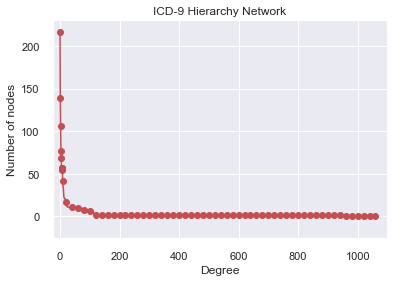

In [10]:
import collections
sns.set()
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

plt.figure() # you need to first do 'import pylab as plt'
plt.grid(True)
plt.plot(degree_sequence, 'r') # in-degree
node_ix = list(np.arange(0,10)) + list(np.arange(20, len(degree_sequence), 20))
plt.scatter(node_ix, np.array(degree_sequence)[node_ix], c='r')
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('ICD-9 Hierarchy Network')
plt.ylim([-25, 230])
plt.xlim([-25, 1100])
plt.show();

In [11]:
# Clustering coefficient of all nodes (in a dictionary)
clust_coefficients = nx.clustering(G)
# Average clustering coefficient
ccs = nx.clustering(G)
avg_clust = sum(ccs.values()) / len(ccs)
print('Avg Clustering Coefficient:', avg_clust)

Avg Clustering Coefficient: 0.8124787447825227


In [12]:
# get largest connected components in G
G_components = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
[len(c) for c in G_components]

[217, 140, 107, 78, 70, 58, 58, 58, 55, 43, 36, 35, 30, 24, 23, 21, 11]

In [13]:
component_graphs = [G.subgraph(c).copy() for c in G_components]
for cg in component_graphs:
    print(np.mean(list(nx.betweenness_centrality(cg).values())))

0.004581700980800755
0.007051253407212119
0.009187931917609221
0.012522565154144103
0.013920350748995251
0.01669043297899922
0.01670123584824129
0.016701235848241295
0.017571945873832664
0.02222942495205683
0.026844070961718022
0.027043544690603515
0.031198686371100164
0.038372859025032936
0.039713909279126665
0.047619047619047616
0.09090909090909091


In [14]:
c = G_components[0]
C = G.subgraph(c).copy()
l1 = list(C.nodes())
#[k:v for k in subchap_range_dict.keys() list(c1.nodes())]
subchaps = set(l1).intersection(set(subchap_range_dict.keys()))
sub_labels = {k:subchap_range_dict[k] for k in subchaps}
chaps = set(l1).intersection(set(chap_range_dict.keys()))
chap_labels = {k:chap_range_dict[k] for k in chaps}

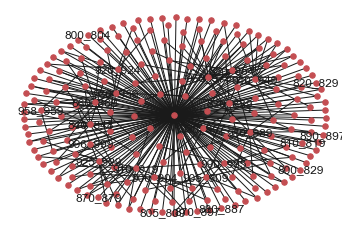

In [15]:
pos=nx.kamada_kawai_layout(C) # positions for all nodes

# nodes
nx.draw_networkx_nodes(C,pos,node_size=30)

# edges
nx.draw_networkx_edges(C,pos)

# labels
nx.draw_networkx_labels(C,pos,{s:s[2:] for s in subchaps},font_size=12)
plt.axis('off')
plt.show(); # display

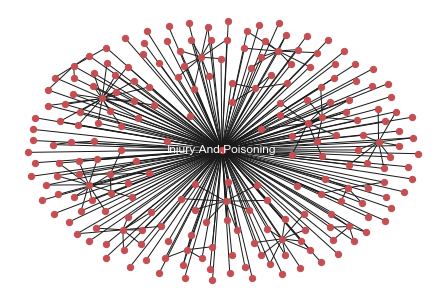

In [16]:
#nx.draw_kamada_kawai(C)

nx.draw(C,labels=chap_labels, font_size=12, font_color='white', node_size=40)
#nx.draw(C, pos=nx.shell_layout(C))

In [17]:
icd_relations = pd.DataFrame(relations, columns=['u', 'v'])
icd_relations['u'] = icd_relations['u'].astype('str')
icd_relations.info()
icd_relations.head()
icd_relations.to_csv('data/icd_data/icd_relations.csv', index=None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1879 entries, 0 to 1878
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   u       1879 non-null   object
 1   v       1879 non-null   object
dtypes: object(2)
memory usage: 29.5+ KB


,u,v
0,001,c_1_139
1,001,s_1_9
2,002,c_1_139
3,002,s_1_9
4,003,c_1_139


In [18]:
# import modules within repository
sys.path.append('C:\\Users\\dreww\\Desktop\\hyperbolic-learning\\utils')
sys.path.append('C:\\Users\\dreww\\Desktop\\hyperbolic-learning\\poincaré_embeddings')
from embed import *
from poincare_embedding import plot_embedding

In [19]:
pd.read_csv('data/icd_data/icd_relations.csv')

,u,v
0,001,c_1_139
1,001,s_1_9
2,002,c_1_139
3,002,s_1_9
4,003,c_1_139
...,...,...
1874,s_958_959,c_800_999
1875,s_960_979,c_800_999
1876,s_980_989,c_800_999
1877,s_990_995,c_800_999


In [20]:
fp = 'data/icd_data/icd_relations.csv'
# train poincare embeddings and save output embed coordinates
train_embeddings(input_path=fp, delimiter=',', output_path='data/icd_data/icd_embeddings.csv', epochs=100, burn_in_alpha=0.01, 
                 batch_size=10, alpha=0.1, negative=20, print_every=100)

INFO:gensim.models.poincare:loading relations from train data..
INFO:gensim.models.poincare:loaded 1880 relations from train data, 1066 nodes
INFO:gensim.models.poincare:training model of size 2 with 1 workers on 1880 relations for 100 epochs and 10 burn-in epochs, using lr=0.10000 burn-in lr=0.01000 negative=20
INFO:gensim.models.poincare:starting burn-in (10 epochs)----------------------------------------
INFO:gensim.models.poincare:training on epoch 1, examples #990-#1000, loss: 30.46
INFO:gensim.models.poincare:time taken for 1000 examples: 0.25 s, 3932.06 examples / s
INFO:gensim.models.poincare:training on epoch 2, examples #990-#1000, loss: 30.42
INFO:gensim.models.poincare:time taken for 1000 examples: 0.24 s, 4143.30 examples / s
INFO:gensim.models.poincare:training on epoch 3, examples #990-#1000, loss: 30.35
INFO:gensim.models.poincare:time taken for 1000 examples: 0.28 s, 3543.00 examples / s
INFO:gensim.models.poincare:training on epoch 4, examples #990-#1000, loss: 30.25


INFO:gensim.models.poincare:time taken for 1000 examples: 0.26 s, 3872.16 examples / s
INFO:gensim.models.poincare:training on epoch 37, examples #990-#1000, loss: 9.16
INFO:gensim.models.poincare:time taken for 1000 examples: 0.27 s, 3700.19 examples / s
INFO:gensim.models.poincare:training on epoch 38, examples #990-#1000, loss: 8.76
INFO:gensim.models.poincare:time taken for 1000 examples: 0.25 s, 3978.83 examples / s
INFO:gensim.models.poincare:training on epoch 39, examples #990-#1000, loss: 8.83
INFO:gensim.models.poincare:time taken for 1000 examples: 0.25 s, 3948.04 examples / s
INFO:gensim.models.poincare:training on epoch 40, examples #990-#1000, loss: 8.78
INFO:gensim.models.poincare:time taken for 1000 examples: 0.26 s, 3856.42 examples / s
INFO:gensim.models.poincare:training on epoch 41, examples #990-#1000, loss: 8.68
INFO:gensim.models.poincare:time taken for 1000 examples: 0.28 s, 3580.99 examples / s
INFO:gensim.models.poincare:training on epoch 42, examples #990-#100

INFO:gensim.models.poincare:training on epoch 85, examples #990-#1000, loss: 6.18
INFO:gensim.models.poincare:time taken for 1000 examples: 0.25 s, 3963.11 examples / s
INFO:gensim.models.poincare:training on epoch 86, examples #990-#1000, loss: 5.92
INFO:gensim.models.poincare:time taken for 1000 examples: 0.25 s, 4026.15 examples / s
INFO:gensim.models.poincare:training on epoch 87, examples #990-#1000, loss: 5.98
INFO:gensim.models.poincare:time taken for 1000 examples: 0.23 s, 4322.94 examples / s
INFO:gensim.models.poincare:training on epoch 88, examples #990-#1000, loss: 5.92
INFO:gensim.models.poincare:time taken for 1000 examples: 0.25 s, 3978.82 examples / s
INFO:gensim.models.poincare:training on epoch 89, examples #990-#1000, loss: 6.30
INFO:gensim.models.poincare:time taken for 1000 examples: 0.22 s, 4535.90 examples / s
INFO:gensim.models.poincare:training on epoch 90, examples #990-#1000, loss: 6.16
INFO:gensim.models.poincare:time taken for 1000 examples: 0.25 s, 4059.39

,node,x,y
0,c_800_999,0.273830,0.322888
1,c_1_139,-0.178226,-0.407799
2,c_140_239,0.187324,-0.921165
3,c_320_389,-0.717456,-0.635689
4,c_390_459,0.715101,-0.584399


['977', '976', '979', '961', 's_960_979', '970', '973', '978', '972', '960']
(73, 2)


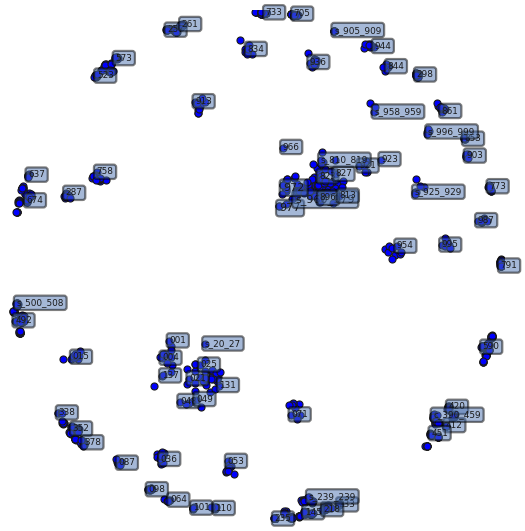

In [21]:
plt.style.use('classic')
plt.rcParams['figure.figsize'] = (6.5, 6.5)
plt.rcParams['figure.facecolor'] = 'white'
emb = load_embeddings('data/icd_data/icd_embeddings.csv')
emb.head()
emb_data = np.array(emb.iloc[:, 1:3])
emb_dict = dict(zip(emb.node.values, emb_data))
plot_embedding(emb_dict, plot_frac=1, label_frac=0.001) #title='Poincaré Embeddings: ICD-9')

## Other source of ICD-9 Data
**data source:** https://github.com/kshedden/icd9

In [97]:
import json
sys.path.append('C:\\Users\\dreww\\Desktop')
from icd9 import icd9
from itertools import combinations
icd_data = icd9.icd9Hierarchy

subchapter_name_range = {}
for i, codes in enumerate(icd_data):
    try:
        if codes['subchapter'] not in subchapter_name_range.keys():
            if i > 0:
                subchapter_name_range[new_sub] = start + '_' + end
            new_sub = codes['subchapter']
            start = codes['threedigit']
        end = codes['threedigit']
    except KeyError:
        continue
subchapter_range_name = {v:k for k,v in subchapter_name_range.items()}

chapters = icd9.icd9Chapters
chapter_name_range = {}
for k,v in chapters.items():
    chapter_name_range[k] = v[0] + '_' + v[1]
chapter_range_name = {v:k for k,v in chapter_name_range.items()}

In [98]:
icd_relations = []
levels = {0:'icd9', 1: 'threedigit', 2: 'subchapter', 3: 'chapter'}
for codes in icd_data:
    for rel in combinations([0, 1, 2, 3], 2):
        try:
            icd_relations.append([codes[levels[rel[0]]], codes[levels[rel[1]]]])
        except KeyError:
            continue

icd_df = pd.DataFrame(icd_relations, columns=['u', 'v'])
icd_df['u'] = icd_df.u.apply(lambda x: subchapter_name_range[x] if x in subchapter_name_range.keys() else x)
icd_df['v'] = icd_df.v.apply(lambda x: subchapter_name_range[x] if x in subchapter_name_range.keys() else x)
icd_df['v'] = icd_df.v.apply(lambda x: chapter_name_range[x] if x in chapter_name_range.keys() else x)
icd_df.head()
icd_df.info()
icd_df.to_csv('data/icd_data/icd_full_relations.csv', index=None)

,u,v
0,0010,001
1,0010,001_009
2,0010,001_139
3,001,001_009
4,001,001_139


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85770 entries, 0 to 85769
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   u       85770 non-null  object
 1   v       85770 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [99]:
chapter_name_label = {}
for i, k in enumerate(chapters.keys()):
    chapter_name_label[k] = i

chapter_range_label = {k:i for i, k in enumerate(chapter_range_name)}

node_labels = {}
for i in range(icd_df.shape[0]):
    u = icd_df.iloc[i, 0]
    v = icd_df.iloc[i, 1]
    if v in chapter_range_label.keys():
        node_labels[u] = chapter_range_label[v]
for k, v in chapter_range_label.items():
    node_labels[k] = v

In [101]:
fp = 'data/icd_data/icd_full_relations.csv'
# train poincare embeddings and save output embed coordinates
train_embeddings(input_path=fp, delimiter=',', output_path='data/icd_data/icd_full_embeddings.csv', epochs=10, burn_in_alpha=0.01, 
                 batch_size=20, burn_in=10, alpha=0.1, negative=10)

INFO:gensim.models.poincare:loading relations from train data..
INFO:gensim.models.poincare:loaded 85771 relations from train data, 15839 nodes
INFO:gensim.models.poincare:training model of size 2 with 1 workers on 85771 relations for 10 epochs and 10 burn-in epochs, using lr=0.10000 burn-in lr=0.01000 negative=10
INFO:gensim.models.poincare:starting burn-in (10 epochs)----------------------------------------
INFO:gensim.models.poincare:training on epoch 1, examples #9980-#10000, loss: 47.93
INFO:gensim.models.poincare:time taken for 10000 examples: 0.99 s, 10074.09 examples / s
INFO:gensim.models.poincare:training on epoch 1, examples #19980-#20000, loss: 47.65
INFO:gensim.models.poincare:time taken for 10000 examples: 1.04 s, 9585.82 examples / s
INFO:gensim.models.poincare:training on epoch 1, examples #29980-#30000, loss: 47.35
INFO:gensim.models.poincare:time taken for 10000 examples: 1.05 s, 9485.72 examples / s
INFO:gensim.models.poincare:training on epoch 1, examples #39980-#40

INFO:gensim.models.poincare:training on epoch 6, examples #59980-#60000, loss: 41.06
INFO:gensim.models.poincare:time taken for 10000 examples: 1.01 s, 9927.12 examples / s
INFO:gensim.models.poincare:training on epoch 6, examples #69980-#70000, loss: 40.84
INFO:gensim.models.poincare:time taken for 10000 examples: 1.07 s, 9344.57 examples / s
INFO:gensim.models.poincare:training on epoch 6, examples #79980-#80000, loss: 40.79
INFO:gensim.models.poincare:time taken for 10000 examples: 1.15 s, 8665.81 examples / s
INFO:gensim.models.poincare:training on epoch 7, examples #9980-#10000, loss: 40.55
INFO:gensim.models.poincare:time taken for 10000 examples: 1.11 s, 9041.25 examples / s
INFO:gensim.models.poincare:training on epoch 7, examples #19980-#20000, loss: 40.54
INFO:gensim.models.poincare:time taken for 10000 examples: 1.27 s, 7889.10 examples / s
INFO:gensim.models.poincare:training on epoch 7, examples #29980-#30000, loss: 40.51
INFO:gensim.models.poincare:time taken for 10000 ex

INFO:gensim.models.poincare:training on epoch 2, examples #49980-#50000, loss: 30.30
INFO:gensim.models.poincare:time taken for 10000 examples: 1.25 s, 7995.79 examples / s
INFO:gensim.models.poincare:training on epoch 2, examples #59980-#60000, loss: 29.90
INFO:gensim.models.poincare:time taken for 10000 examples: 1.12 s, 8920.57 examples / s
INFO:gensim.models.poincare:training on epoch 2, examples #69980-#70000, loss: 29.44
INFO:gensim.models.poincare:time taken for 10000 examples: 1.06 s, 9405.60 examples / s
INFO:gensim.models.poincare:training on epoch 2, examples #79980-#80000, loss: 28.90
INFO:gensim.models.poincare:time taken for 10000 examples: 0.99 s, 10087.25 examples / s
INFO:gensim.models.poincare:training on epoch 3, examples #9980-#10000, loss: 27.59
INFO:gensim.models.poincare:time taken for 10000 examples: 0.95 s, 10488.22 examples / s
INFO:gensim.models.poincare:training on epoch 3, examples #19980-#20000, loss: 27.06
INFO:gensim.models.poincare:time taken for 10000 

INFO:gensim.models.poincare:time taken for 10000 examples: 0.91 s, 10978.99 examples / s
INFO:gensim.models.poincare:training on epoch 8, examples #49980-#50000, loss: 15.87
INFO:gensim.models.poincare:time taken for 10000 examples: 1.11 s, 8982.33 examples / s
INFO:gensim.models.poincare:training on epoch 8, examples #59980-#60000, loss: 15.83
INFO:gensim.models.poincare:time taken for 10000 examples: 1.02 s, 9771.57 examples / s
INFO:gensim.models.poincare:training on epoch 8, examples #69980-#70000, loss: 15.80
INFO:gensim.models.poincare:time taken for 10000 examples: 0.98 s, 10210.04 examples / s
INFO:gensim.models.poincare:training on epoch 8, examples #79980-#80000, loss: 15.57
INFO:gensim.models.poincare:time taken for 10000 examples: 1.23 s, 8112.26 examples / s
INFO:gensim.models.poincare:training on epoch 9, examples #9980-#10000, loss: 15.20
INFO:gensim.models.poincare:time taken for 10000 examples: 1.05 s, 9530.78 examples / s
INFO:gensim.models.poincare:training on epoch 

,node,x,y
0,800_999,-0.490784,0.407609
1,320_389,-0.526389,-0.610117
2,E000_E999,0.094436,0.344550
3,001_139,-0.783218,-0.177046
4,V01_V91,0.560352,0.284942


['28310', '2878', '28268', '7578', '75314', '75244', '2862', '28951', '7458', '75241']
(8, 2)


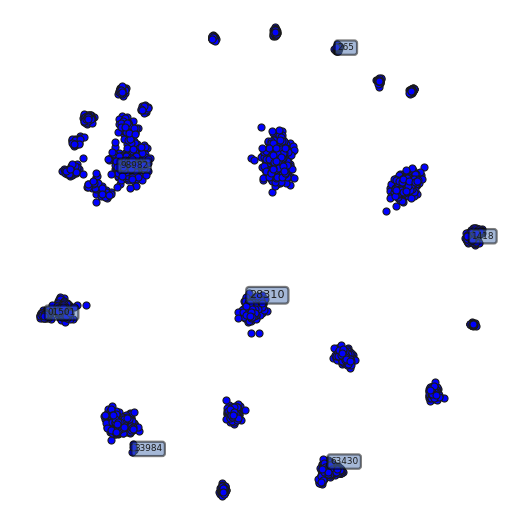

In [102]:
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = (6.5, 6.5)
emb = load_embeddings('data/icd_data/icd_full_embeddings.csv', delim=' ')
emb.head()
emb_data = np.array(emb.iloc[:, 1:3])
emb_dict = dict(zip(emb.node.values, emb_data))
plot_embedding(emb_dict, plot_frac=0.25, label_frac=0.1)

In [129]:
sys.path.append('C:\\Users\\dreww\\Desktop\\vu-informatics\\utils')
from poincare_viz_icd import *
edge_list = [list(arr) for arr in np.array(icd_df)]
labels = emb.node.apply(lambda x: node_labels[x])
chapter_label_range = {v:k for k,v in chapter_range_label.items()}
chapter_name_label

{'Infectious And Parasitic Diseases': 0,
 'Neoplasms': 1,
 'Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders': 2,
 'Diseases Of The Blood And Blood-Forming Organs': 3,
 'Mental Disorders': 4,
 'Diseases Of The Nervous System And Sense Organs': 5,
 'Diseases Of The Circulatory System': 6,
 'Diseases Of The Respiratory System': 7,
 'Diseases Of The Digestive System': 8,
 'Diseases Of The Genitourinary System': 9,
 'Complications Of Pregnancy, Childbirth, And The Puerperium': 10,
 'Diseases Of The Skin And Subcutaneous Tissue': 11,
 'Diseases Of The Musculoskeletal System And Connective Tissue': 12,
 'Congenital Anomalies': 13,
 'Certain Conditions Originating In The Perinatal Period': 14,
 'Symptoms, Signs, And Ill-Defined Conditions': 15,
 'Injury And Poisoning': 16,
 'Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services': 17,
 'Supplementary Classification Of External Causes Of Injury And Poisoning': 18}

In [138]:
def plot_poincare_icd(emb, labels, edge_list, legend_headers=None, title=None, height=8, width=8,
                  add_labels=False, label_dict=None, plot_frac=1, edge_frac=1, label_frac=0.001):
    # Note: parameter 'emb' expects data frame with node ids and coords
    emb.columns = ['node', 'x', 'y']
    n_classes = len(np.unique(labels))
    plt.figure(figsize=(width, height))
    plt.xlim([-1.0, 1.0])
    plt.ylim([-1.0,1.0])
    ax = plt.gca()
    circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.8)
    ax.add_patch(circ)
    
    # set colormap,
    if n_classes <= 12:
        colors = ['b', 'r', 'g', 'y', 'm', 'c', 'k', 'silver', 'lime', 'skyblue', 'maroon', 'darkorange']
    elif 12 < n_classes <= 20:
        colors = [i for i in plt.cm.get_cmap('tab20').colors]
    else:
        cmap = plt.cm.get_cmap(name='viridis')
        colors = cmap(np.linspace(0, 1, n_classes))

    # plot embedding coordinates
    emb_data = np.array(emb.iloc[:, 1:3])
    for i in range(n_classes):
        plt.scatter(emb_data[(labels == i), 0], emb_data[(labels == i), 1],
                             color = colors[i], alpha=0.8, edgecolors='black', linewidth=1, s=35)
    # plot edges,
    for i in range(int(len(edge_list) * edge_frac)):
        x1 = emb.loc[(emb.iloc[:, 0] == edge_list[i][0]), ['x', 'y']].values[0]
        x2 = emb.loc[(emb.node == edge_list[i][1]), ['x', 'y']].values[0]
        _ = plt.plot([x1[0], x2[0]], [x1[1], x2[1]], '--', c='black', linewidth=1, alpha=0.35)
    
    # add labels to embeddings,
    if add_labels and label_dict != None:
        plt.grid('off')
        plt.axis('off')
        embed_vals = np.array(list(label_dict.values()))
        keys = list(label_dict.keys())
        # set threshhold to limit plotting labels too close together
        min_dist_2 = label_frac * max(embed_vals.max(axis=0) - embed_vals.min(axis=0)) ** 2
        labeled_vals = np.array([2*embed_vals.max(axis=0)])
        n = int(plot_frac*len(embed_vals))
        for i in np.random.permutation(len(embed_vals))[:n]:
            if np.min(dist_squared(embed_vals[i], labeled_vals, axis=1)) < min_dist_2:
                continue
            else:
                props = dict(boxstyle='round', lw=2, edgecolor='black', alpha=0.35)
                _ = ax.text(embed_vals[i][0], embed_vals[i][1]+0.02, s=keys[i].split('.')[0],
                            size=10, fontsize=12, verticalalignment='top', bbox=props)
                labeled_vals = np.vstack((labeled_vals, embed_vals[i]))
    if title != None:
        plt.suptitle('ICD-9: Poicare Embedding' + title, size=16);
    if legend_headers != None:
        plt.legend(loc='best')
    plt.show();

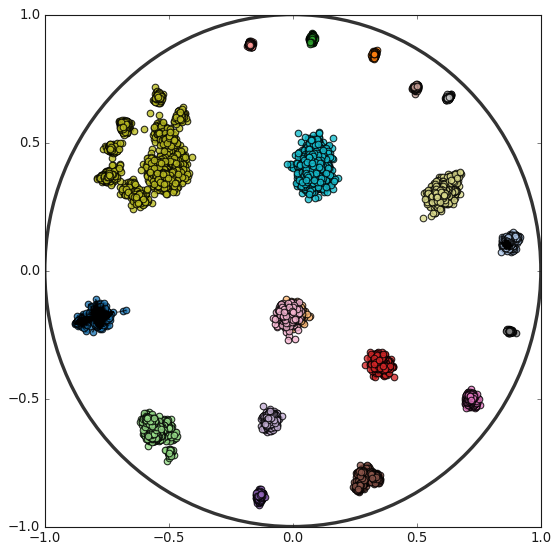

In [139]:
plot_poincare_icd(emb, labels, edge_list, edge_frac=0.1)

___
### References: <br>


**[1]**. Weng, Wei-Hung and Peter Szolovits. “Representation Learning for Electronic Health Records.” ArXiv abs/1909.09248 (2019): n. pag.

**[2]** Beaulieu-Jones, Brett & Kohane, Isaac & Beam, Andrew. (2019). Learning Contextual Hierarchical Structure of Medical Concepts with Poincairé Embeddings to Clarify Phenotypes. Pacific Symposium on Biocomputing. Pacific Symposium on Biocomputing. 24. 8-17. 

**[3]** Cao, Jiazhen. “A Case Study for Predicting in-Hospital Mortality by Utilizing the Hyperbolic Embedding of ICD-9 Medical Ontology.” (2019).

**[4]** Learning Electronic Health Records through Hyperbolic Embedding of Medical Ontologies: https://dl.acm.org/doi/pdf/10.1145/3307339.3342148

<br>
___